# Курсовой проект

Задание: Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная: Price

Метрика качества: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:

R2 > 0.6
Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).
Сроки сдачи: Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.
Описание датасета: Id - идентификационный номер квартиры DistrictId - идентификационный номер района Rooms - количество комнат Square - площадь LifeSquare - жилая площадь KitchenSquare - площадь кухни Floor - этаж HouseFloor - количество этажей в доме HouseYear - год постройки дома Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности Social_1, Social_2, Social_3 - социальные показатели местности Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров Price - цена квартиры

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("default")

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'C:/Users/MI/GeekBrains/Python Libraries/project_task/train.csv'
TEST_DATASET_PATH = 'C:/Users/MI/GeekBrains/Python Libraries/project_task/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [12]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

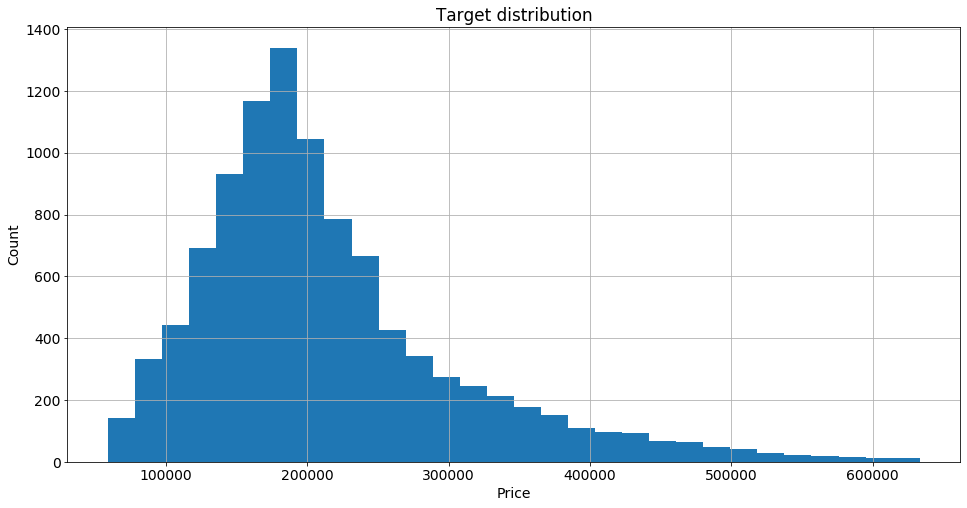

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [15]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


**Номинативные переменные**

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
train_df['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

**Rooms**

In [21]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [22]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [23]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [24]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [25]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [26]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9536.000000,9536.000000,7478.000000,9536.000000,9536.000000,9536.000000,9.536000e+03,9536.000000,9536.000000,9536.000000,9536.000000,4996.000000,9536.000000,9536.000000,9536.000000
mean,1.877097,55.087703,35.296505,6.343226,8.522651,12.651426,4.087229e+03,0.119587,24.918834,5397.071623,8.072462,1139.407526,1.327076,4.263213,212418.986693
std,0.794314,16.300058,14.742250,2.846826,5.180528,6.624559,2.053203e+05,0.119750,17.505763,4002.952967,23.820736,1020.092186,1.486836,4.803985,89285.705235
min,1.000000,29.719934,2.941437,3.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.784346,23.009265,3.000000,4.000000,9.000000,1.973000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,154362.155371
50%,2.000000,52.073571,32.721505,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,191945.213935
75%,2.000000,65.094673,44.583199,9.000000,12.000000,17.000000,1.999000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,247378.811874
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [27]:
train_df.shape

(9536, 20)

**HouseFloor, Floor**

In [28]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        38.,  39.,  40.,  44.,  45.,  48.,  99., 117.])

In [29]:
(train_df['HouseFloor'] == 0).value_counts()

False    9285
True      251
Name: HouseFloor, dtype: int64

In [30]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [31]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [32]:
(test_df['HouseFloor'] == 0).value_counts()

False    4869
True      131
Name: HouseFloor, dtype: int64

In [33]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [34]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [35]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
len(floor_outliers)

1476

In [36]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [37]:
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
len(floor_outliers_test)

780

In [38]:
test_df.loc[floor_outliers_test, 'Floor'] = test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [39]:
train_df['HouseYear'].sort_values(ascending=False).head()

1497    20052011
4189        4968
7076        2020
2493        2020
4053        2020
Name: HouseYear, dtype: int64

In [40]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [41]:
test_df['HouseYear'].sort_values(ascending=False)

4389    2020
4273    2020
888     2020
3255    2020
1039    2020
3382    2020
4777    2020
1275    2020
385     2020
2239    2019
61      2019
4953    2019
775     2019
2566    2019
3326    2019
3080    2019
1947    2019
1351    2019
4516    2019
1554    2019
1641    2019
422     2019
3406    2019
1953    2019
3769    2019
2062    2019
1384    2019
847     2019
122     2019
4505    2019
        ... 
623     1931
1456    1931
2494    1930
1444    1930
1783    1930
3668    1930
51      1929
2137    1929
255     1929
2582    1929
2053    1929
3695    1928
4756    1928
3660    1928
2086    1927
3571    1927
4159    1927
1482    1926
523     1926
4831    1920
3337    1918
3654    1918
2323    1918
600     1917
2856    1914
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: int64

### Обработка пропусков

In [42]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2058
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4540
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [43]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [44]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,3.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,NaN,3.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0


**LifeSquare**

In [45]:
train_df['LifeSquare'].median()

32.7215045443441

In [46]:
test_df['LifeSquare'].median()

32.92508663208161

In [47]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.39563545061383

In [48]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [49]:
train_df['LifeSquare'].median()

33.7008359485593

In [50]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [51]:
test_df['LifeSquare'].median()

34.3190758440274

**Healthcare_1**

In [52]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [53]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [54]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [55]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [56]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,780
1,1,636
2,23,517
3,6,495
4,9,279


In [57]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,172
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,173
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,95


In [58]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,B,1,1,1,173.0
1,15856,74,2.0,69.263183,56.867548,1.0,1,1.0,1977,0.075779,...,1437,3,900.0,0,2,B,1,1,1,109.0
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,7.0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,B,1,1,1,97.0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,780.0


In [59]:
(train_df['DistrictSize'] > 100).value_counts()

False    4827
True     4709
Name: DistrictSize, dtype: int64

In [60]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [61]:
(test_df['DistrictSize'] > 100).value_counts()

False    2612
True     2388
Name: DistrictSize, dtype: int64

In [62]:
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [63]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146341.760143
4,1,2.0,202626.530012


In [64]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,172,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,173,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,95,0,158791.017955


In [65]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,900.0,0,0,B,1,1,1,173.0,1,166809.665642
1,15856,74,2.0,69.263183,56.867548,1.0,1,1.0,1977,0.075779,...,900.0,0,2,B,1,1,1,109.0,1,243031.695525
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,1,1,1,7.0,0,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,900.0,3,3,B,1,1,1,97.0,0,222227.584211
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,900.0,0,0,A,1,1,0,780.0,1,119191.410476


In [66]:
test_df.loc[test_df['MedPriceByDistrict'].isna(), 'MedPriceByDistrict'] = train_df['MedPriceByDistrict'].median()

In [67]:
med_price_by_square = train_df.groupby(['Square'], as_index=False).agg({'Price':'median'})\
                      .rename(columns={'Price':'MedPriceBySquare'})

In [68]:
med_price_by_square.head()

,Square,MedPriceBySquare
0,29.719934,63033.520743
1,29.721866,143442.033634
2,29.833612,68185.043135
3,29.879036,67898.291266
4,29.947691,99110.577389


In [69]:
med_price_by_district.dtypes

DistrictId             object
Rooms                 float64
MedPriceByDistrict    float64
dtype: object

In [70]:
train_df = train_df.merge(med_price_by_square, on='Square', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceBySquare
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,1,1,1,22,0,207786.135836,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,1,1,1,86,0,300009.450063,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,3,B,220925.908524,1,1,1,172,1,263206.223152,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,1,1,1,173,1,166809.665642,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,1,1,1,95,0,158791.017955,150226.531644


In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
Id                    5000 non-null object
DistrictId            5000 non-null object
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            5000 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null int64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null int64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null object
Ecology_3             5000 non-null object
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Healthcare_1          5000 non-null float64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2               5000 non-null object
Ecology_2_bin         5000 non-null int64
Ecology_3_bin         5000 non-nul

### Отбор признаков

In [72]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'MedPriceBySquare']

In [73]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и test

In [74]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [76]:
rf_model = RandomForestRegressor(n_estimators = 10, criterion='mse', random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

**Отложенная выборка**

Train R2:	0.95
Test R2:	0.734


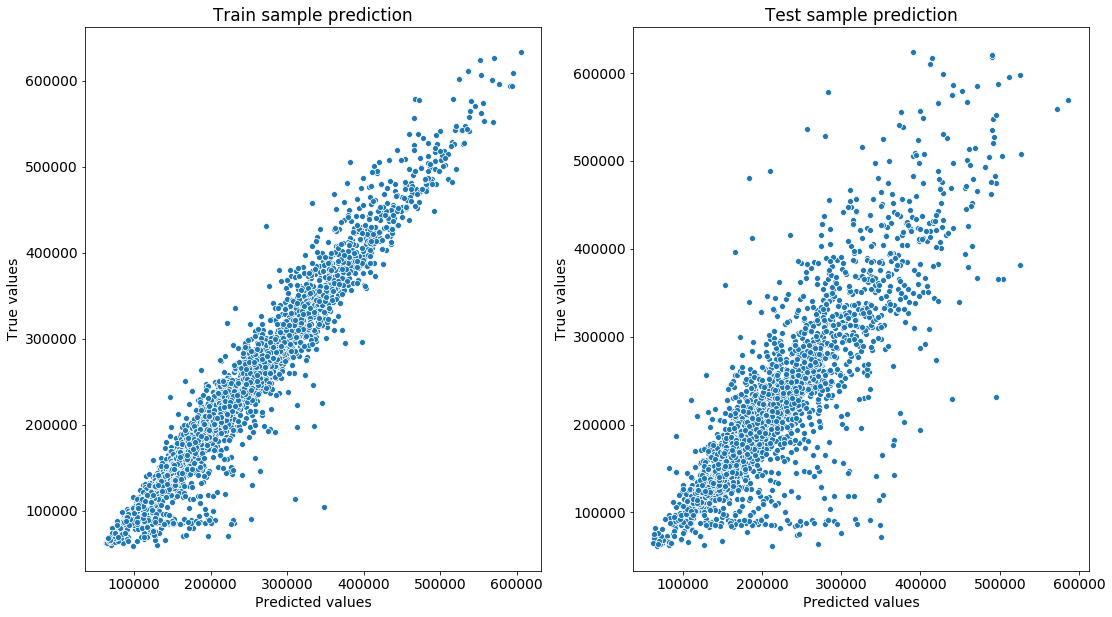

In [77]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [78]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.7401697 , 0.73257312, 0.70425246])

In [79]:
cv_score.mean()

0.725665095345336

**Важность признаков**

In [80]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.638988
1,Square,0.105246
2,LifeSquare,0.034584
6,HouseYear,0.033743
12,Social_3,0.026801
5,HouseFloor,0.023788
4,Floor,0.022976
3,KitchenSquare,0.022745
7,Ecology_1,0.017480
10,Social_1,0.016472


### Прогнозирование на тестовом датасете


In [81]:
X_test_final = test_df[feature_names + new_feature_names]

In [82]:
X_test_final.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,MedPriceByDistrict
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,900.0,0,0,1,1,166809.665642
1,2.0,69.263183,56.867548,1.0,1,1.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,1,243031.695525
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,0,195641.106322
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,900.0,3,3,1,0,222227.584211
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,1,119191.410476


In [83]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            5000 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null int64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null int64
Ecology_1             5000 non-null float64
Ecology_2_bin         5000 non-null int64
Ecology_3_bin         5000 non-null int64
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Healthcare_1          5000 non-null float64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2_bin           5000 non-null int64
IsDistrictLarge       5000 non-null int32
MedPriceByDistrict    5000 non-null float64
dtypes: float64(8), int32(1), int64(10)
memory usage: 761.7 KB


In [84]:
prediction = pd.DataFrame()
prediction['Id'] = test_df['Id']

In [85]:
y_test_final = rf_model.predict(X_test_final)

prediction['Price'] = y_test_final
prediction.to_csv('KuftyrevRoman_predictions.csv', index=False)

prediction.head()

,Id,Price
0,725,158453.566883
1,15856,239806.970327
2,5480,186969.971614
3,15664,295590.363987
4,14275,154737.610641
